<a href="https://colab.research.google.com/github/dohyun93/hongong_mldl/blob/main/9_3_LSTM%EA%B3%BC_GRU_%EC%85%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM (Long Short-Term Memory)

> 9-1 절에서 본 기본 순환신경망은 시퀀스의 길이가 길어질수록 순환되는 앞 토큰의 은닉 상태의 정보가 점차 희석되기 때문에, 멀리 떨어져있는 단어 정보를 인식하는데 어려울 수 있다. 이러한 배경으로 LSTM, GRU 셀이 발명되었다.

> LSTM은 총 4개의 셀로 이루어져있으며, 단기 기억을 오래 기억하기 위해 고안되었다. 아래 그림에서 볼 수 있듯이, 각 활성함수에 들어가는 입력/은닉 상태들에 대한 가중치가 '각각' 존재한다. 기본 RNN대비해서 은닉 상태 외 '셀상태'라는 것이 존재한다. 이는 다음 층으로 전달되지 않고, LSTM 셀에서 순환만 하는 값이다. [LSTM 참고링크](https://wikidocs.net/166317)

> 각 셀을 위한 가중치가 존재하며, 3개의 게이트가 존재한다.

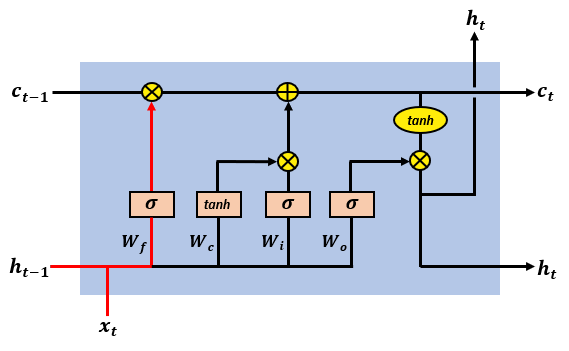

In [8]:
# LSTM 신경망 훈련하기
# 1. IMDB 리뷰 데이터를 로드하고 훈련/검증 세트로 나누자.

from tensorflow import keras
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) =\
imdb.load_data(num_words=500)

train_input, val_input, train_target, val_target =\
train_test_split(train_input, train_target, random_state=30, test_size=0.2)

In [9]:
print(train_input.shape)
print(len(train_input[0]))
print(len(train_input[1]))

# 2. 확인했던 것처럼 각 샘플의 길이가 다르다. 
# pad_sequences() 함수로 Imdb 시퀀스 데이터의 각 샘플의 길이를 100으로 맞추고, 부족하면 패딩을 추가하자.
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

(20000,)
157
209


In [11]:
# 3. 이제 LSTM 을 활용한 순환층을 만들어보자.
from tensorflow import keras

model = keras.Sequential()
model.add(keras.layers.Embedding(500, 16, input_length=100)) # 500개의 어휘사전, 임베딩 벡터의 크기를 16으로 지정.
model.add(keras.layers.LSTM(8)) 
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 16)           8000      
                                                                 
 lstm_1 (LSTM)               (None, 8)                 800       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,809
Trainable params: 8,809
Non-trainable params: 0
_________________________________________________________________


In [18]:
# LSTM(8)에서 8은 은닉 상태 크기이다.

# SimpleRNN 에서는 모델 파라미터가 200개였다.
# 16 * 8 + 8 * 8 + 8 = 128 + 64 + 8 = 200. (SimpleRNN)
# LSTM 은 셀이 1개가 아니라 4개이므로, 200 * 4 = 800 개의 모델 파라미터가 존재한다.

# 4. 모델을 컴파일하고 훈련해보자.
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(train_seq, train_target, callbacks=[checkpoint_cb, early_stopping_cb], validation_data=(val_seq, val_target), epochs=100, batch_size=64)

Epoch 1/100
313/313 [==============================] - 16s 45ms/step - loss: 0.4115 - accuracy: 0.8156 - val_loss: 0.4363 - val_accuracy: 0.7998
Epoch 2/100
313/313 [==============================] - 13s 42ms/step - loss: 0.4106 - accuracy: 0.8159 - val_loss: 0.4364 - val_accuracy: 0.8000
Epoch 3/100
313/313 [==============================] - 14s 43ms/step - loss: 0.4099 - accuracy: 0.8163 - val_loss: 0.4377 - val_accuracy: 0.7972
Epoch 4/100
313/313 [==============================] - 16s 51ms/step - loss: 0.4086 - accuracy: 0.8181 - val_loss: 0.4369 - val_accuracy: 0.7972


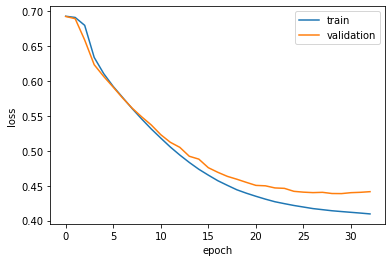

In [13]:
# 위 훈련 결과에 대해 훈련/검증세트에 대한 학습경과를 도식화해보자.
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'])
plt.show()

# 순환층에 드롭아웃 적용하기

> SimpleRNN 대비해서 훈련세트의 성능이 오히려 조금 낮아지긴 했지만 검증세트는 조금 늘어났다.

> Epoch 24/100
313/313 [==============================] - 6s 18ms/step - loss: 0.4101 - accuracy: 0.8238 - val_loss: 0.4648 - val_accuracy: 0.7866

> Epoch 25/100
313/313 [==============================] - 6s 18ms/step - loss: 0.4069 - accuracy: 0.8242 - val_loss: 0.4597 - val_accuracy: 0.7916

> Epoch 26/100
313/313 [==============================] - 6s 18ms/step - loss: 0.4037 - accuracy: 0.8249 - val_loss: 0.4603 - val_accuracy: 0.7914

> Epoch 27/100
313/313 [==============================] - 6s 19ms/step - loss: 0.4010 - accuracy: 0.8279 - val_loss: 0.4612 - val_accuracy: 0.7928

> Epoch 28/100
313/313 [==============================] - 6s 18ms/step - loss: 0.3986 - accuracy: 0.8260 - val_loss: 0.4612 - val_accuracy: 0.7888

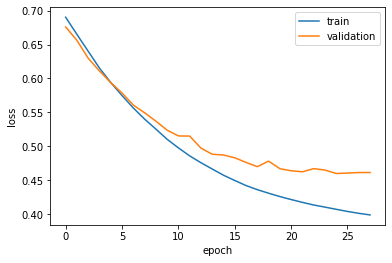

> 경우에 따라서는 과대적합을 더 강하게 제어할 필요가 있는데, 그렇다면 드롭아웃(7장)을 순환층에도 적용해보자.

In [14]:
# 순환층에 드롭아웃 적용하기.
# 완전 연결 신경망과 합성곱 신경망 에서는 Dropout 클래스를 사용해 드롭아웃을 적용했고, 이를 통해 모델이 훈련 세트에 너무 과대적합 되는 것을 방지했다.

# 순환층은 '자체적으로' 드롭아웃 기능을 제공한다.
# SimpleRNN, LSTM 클래스들 모두 'dropout', 'recurrent_dropout' 매개변수를 가지고 있다.

# dropout : 셀의 입력에 드롭아웃을 적용. (여기서 사용)
# recurrent_dropout : 순환되는 은닉 상태에 드롭아웃을 적용. GPU를 사용하므로 모델의 훈련속도가 매우 느려진다. (여기서는 사용X)

# 전체적인 모델 구조는 동일하나, LSTM 클래스에 dropout 매개변수를 0.3 으로 지정해서 30% 의 입력을 드롭아웃한다.
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(500, 16, input_length=100))
model2.add(keras.layers.LSTM(8, dropout=0.3))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, metrics=['accuracy'], loss='binary_crossentropy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-dropout-lstm-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model2.fit(train_seq, train_target, callbacks=[checkpoint_cb, early_stopping_cb], epochs=100, batch_size=64, validation_data=(val_seq, val_target))

Epoch 1/100
313/313 [==============================] - 19s 53ms/step - loss: 0.6928 - accuracy: 0.5214 - val_loss: 0.6917 - val_accuracy: 0.5714
Epoch 2/100
313/313 [==============================] - 20s 65ms/step - loss: 0.6892 - accuracy: 0.6055 - val_loss: 0.6857 - val_accuracy: 0.6284
Epoch 3/100
313/313 [==============================] - 17s 53ms/step - loss: 0.6637 - accuracy: 0.6617 - val_loss: 0.6247 - val_accuracy: 0.7012
Epoch 4/100
313/313 [==============================] - 16s 50ms/step - loss: 0.6045 - accuracy: 0.7078 - val_loss: 0.5884 - val_accuracy: 0.7198
Epoch 5/100
313/313 [==============================] - 18s 58ms/step - loss: 0.5733 - accuracy: 0.7291 - val_loss: 0.5600 - val_accuracy: 0.7444
Epoch 6/100
313/313 [==============================] - 18s 58ms/step - loss: 0.5459 - accuracy: 0.7452 - val_loss: 0.5335 - val_accuracy: 0.7570
Epoch 7/100
313/313 [==============================] - 16s 51ms/step - loss: 0.5210 - accuracy: 0.7628 - val_loss: 0.5135 - val_ac

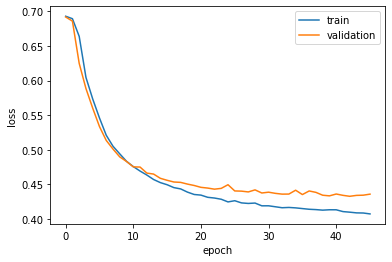

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'])
plt.show()

사실상 거의 차이가 없지만, 드롭아웃을 적용한 결과 훈련,검증 손실이 약간 더 적어진 것으로 확인된다.

이제 LSTM 층을 하나 더 추가해서 모델을 만들어보자.

In [17]:
# 순환층이 연결되어 있을 경우, 앞의 순환층에서는 모든 타임스텝에 대한 은닉상태를 출력해야하고, 마지막 순환층만 마지막 타임스텝의 은닉 상태를 출력해야한다.
# 이를 참고해서 2개 LSTM 층으로 이루어진 모델을 만들어보자.

model3 = keras.Sequential()
model3.add(keras.layers.Embedding(500, 16, input_length=100))
model3.add(keras.layers.LSTM(8, dropout=0.3, return_sequences=True)) # 모든 타임스텝에 대하여 은닉 상태를 출력하도록 설정.
model3.add(keras.layers.LSTM(8, dropout=0.3))
model3.add(keras.layers.Dense(1, activation='sigmoid'))

model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 16)           8000      
                                                                 
 lstm_5 (LSTM)               (None, 100, 8)            800       
                                                                 
 lstm_6 (LSTM)               (None, 8)                 544       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 9,353
Trainable params: 9,353
Non-trainable params: 0
_________________________________________________________________


In [19]:
# 첫 번째 LSTM 층이 모든 타입스텝(100개)의 은닉 상태(8)를 출력하기 때문에, 출력 크기가 (None, 100, 8) 이다.
# 두 번째 LSTM 층은 마지막 타임스텝의 은닉 상태만 출력하기 때문에, 출력 크기가 (None, 8) 이다.

'''
코퍼스의 각 샘플의 maxlen=100 으로 pad_sequences 를 적용했기 때문에, 각 샘플을 이루는 모든 토큰의 개수가 곧 모든 타임스텝의 크기와 같고, 이는 곧 100이다.
즉, 각 타임스텝은 코퍼스의 각 샘플을 이루는 각 토큰을 처리하는 단계다.
'''

rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model3.compile(optimizer=rmsprop, metrics=['accuracy'], loss='binary_crossentropy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-2lstm-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model3.fit(train_seq, train_target, epochs=100, batch_size=64, callbacks=[checkpoint_cb, early_stopping_cb], validation_data=(val_seq, val_target))

Epoch 1/100
313/313 [==============================] - 33s 90ms/step - loss: 0.6927 - accuracy: 0.5325 - val_loss: 0.6921 - val_accuracy: 0.5588
Epoch 2/100
313/313 [==============================] - 31s 98ms/step - loss: 0.6902 - accuracy: 0.5897 - val_loss: 0.6878 - val_accuracy: 0.5816
Epoch 3/100
313/313 [==============================] - 36s 114ms/step - loss: 0.6748 - accuracy: 0.6083 - val_loss: 0.6532 - val_accuracy: 0.6682
Epoch 4/100
313/313 [==============================] - 33s 105ms/step - loss: 0.6119 - accuracy: 0.7096 - val_loss: 0.5766 - val_accuracy: 0.7352
Epoch 5/100
313/313 [==============================] - 34s 107ms/step - loss: 0.5555 - accuracy: 0.7369 - val_loss: 0.5366 - val_accuracy: 0.7502
Epoch 6/100
313/313 [==============================] - 30s 95ms/step - loss: 0.5311 - accuracy: 0.7478 - val_loss: 0.5189 - val_accuracy: 0.7616
Epoch 7/100
313/313 [==============================] - 33s 105ms/step - loss: 0.5153 - accuracy: 0.7591 - val_loss: 0.5064 - va

In [ ]:
'''
dropout 을 적용한 1층 LSTM 모델의 성능 대비해서 약간 개선된 것으로 보인다.
일반적으로 순환층을 쌓으면 성능이 높아진다.
'''

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
'''
그래프를 보면 과대적합은 제어하면서, 손실을 최대한 낮춘 것으로 보인다.
지금까지 LSTM 셀을 이용해서 훈련, 드롭아웃을 해보았고, 2개의 LSTM 순환층을 쌓은 순환 신경망을 만들어 보았다.
이제 또 다른 유명한 셀인 GRU 셀에 대해 알아보자.
'''

# GRU (Gated Recurrent Unit)

> NYU 조경현 교수님이 발명한 셀로, 쉽게 LSTM 을 간소화한 버전이라고 생각하면 된다.

> GRU 셀에는 LSTM과 다르게 셀 상태가 없고 은닉 상태만 존재한다.

> GRU 셀에는 입력과 은닉상태에 가중치를 곱하고 절편을 더하는 3개의 작은 셀이 있다. 2개는 sigmoid, 1개는 tanh 활성함수를 사용한다.

> GRU 셀은 LSTM 보다 가중치가 적기 때문에 계산량이 적지만, LSTM 못지않은 성능을 내는 것으로 알려져있다. 연구자들과 엔지니어들은 보통 둘 다를 사용해서 어떤 모델이 더 나은지 비교해본다.

> GRU 셀을 이해하기 쉽게 아래 LSTM 과 비교한 도식을 살펴보자. ([출처](https://wikidocs.net/166319))

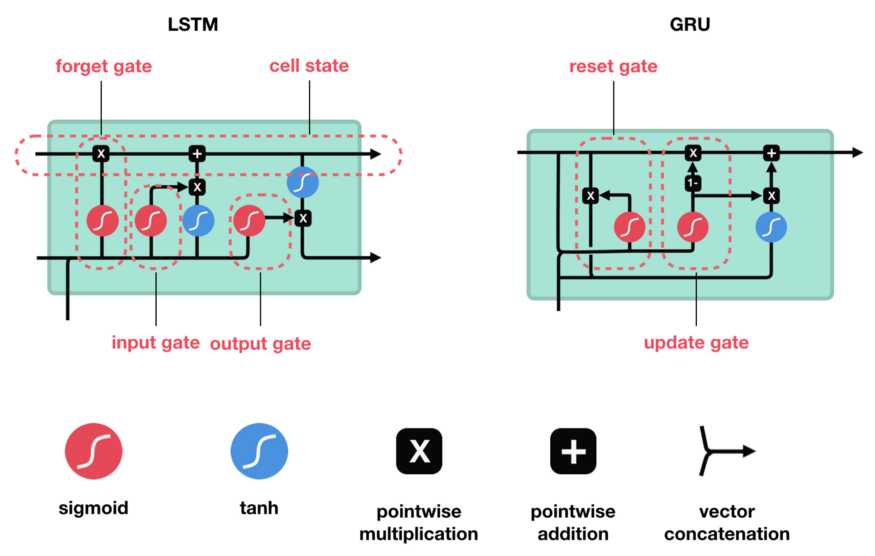



In [20]:
model4 = keras.Sequential()

model4.add(keras.layers.Embedding(500, 16, input_length=100))
model4.add(keras.layers.GRU(8))
model4.add(keras.layers.Dense(1, activation='sigmoid'))

model4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 16)           8000      
                                                                 
 gru (GRU)                   (None, 8)                 624       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,633
Trainable params: 8,633
Non-trainable params: 0
_________________________________________________________________


In [23]:
'''
GRU 셀의 모델 파라미터 개수가 624개인 이유
임베딩 벡터 (입력) 크기 16 * 은닉 상태 (=뉴런개수) 8 = 128
은닉상태 자기자신 입력 8 * 8 = 64
뉴런마다 존재하는 절편 8
-> 200개.
-> 총 3개 셀이 있으므로 3 * 200 = 600개.

24개는 뭘까?
실제 이론과 달리 케라스 구현은 은닉 상태가 먼저 가중치와 곱해진 다음 다른 셀의 출력과 곱해지기 때문에
가중치가 나누어졌다. 따라서 작은 셀 마다 하나씩 절편이 추가되고, 총 8개 뉴런이 있으므로 24개의 모델 파라미터가 더해진다.
'''

rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model4.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-gru-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(train_seq, train_target, validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb], epochs=100, batch_size=64)

Epoch 1/100
313/313 [==============================] - 14s 44ms/step - loss: 0.4098 - accuracy: 0.8162 - val_loss: 0.4451 - val_accuracy: 0.7962
Epoch 2/100
313/313 [==============================] - 13s 43ms/step - loss: 0.4088 - accuracy: 0.8159 - val_loss: 0.4420 - val_accuracy: 0.7972
Epoch 3/100
313/313 [==============================] - 13s 42ms/step - loss: 0.4082 - accuracy: 0.8170 - val_loss: 0.4356 - val_accuracy: 0.7986
Epoch 4/100
313/313 [==============================] - 13s 42ms/step - loss: 0.4076 - accuracy: 0.8158 - val_loss: 0.4363 - val_accuracy: 0.7994
Epoch 5/100
313/313 [==============================] - 13s 43ms/step - loss: 0.4068 - accuracy: 0.8173 - val_loss: 0.4351 - val_accuracy: 0.7990
Epoch 6/100
313/313 [==============================] - 13s 42ms/step - loss: 0.4060 - accuracy: 0.8182 - val_loss: 0.4357 - val_accuracy: 0.7990
Epoch 7/100
313/313 [==============================] - 13s 42ms/step - loss: 0.4050 - accuracy: 0.8178 - val_loss: 0.4343 - val_ac

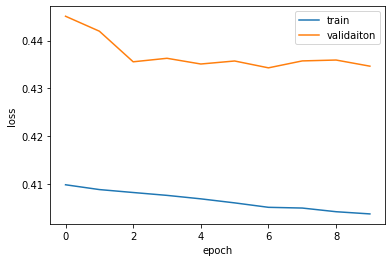

In [24]:
'''
LSTM과 거의 비슷한 성능을 보인다. 드롭아웃을 적용하지 않아 훈련/검증 손실이 다소 차이가 있지만, 훈련과정이 잘 수렴되고 있는 걸 볼 수 있다.
GRU 모델의 손실을 도식화해보자.
'''

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validaiton'])
plt.show()